In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.optim import AdamW
from models import get_model
from utils import get_loader, train, test, evaluation
from tqdm.auto import tqdm

# Homograph

In [2]:
loader_name = "Neighbor"
hidden_size = 128
model_name = 'GraphSAGE'
learning_rate = 0.002
epoch_num = 200
data_path = 'data/processed/data_homo.pt'
model_save_path = 'models/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = torch.load(data_path)
edge_type = data.edge_attr[:, 1:].argmax(dim=1)
train_loader, val_loader, test_loader = get_loader(data, loader_name)

/data/GNN Project/GNN-land-use/pytorch_geometric/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [4]:
num_features = data.x.shape[1]
num_classes = data.y.shape[1]
model = get_model(model_name, num_features, hidden_size, num_classes, device)
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [5]:
loss_history = []
val_acc_history = []
test_acc_history = []
for epoch in tqdm(range(1, epoch_num + 1)):
    loss = train(model_name, model, train_loader, optimizer, device)
    val_acc = test(model_name, model, val_loader, device)
    test_acc = test(model_name, model, test_loader, device)
    loss_history.append(loss)
    val_acc_history.append(val_acc)
    test_acc_history.append(test_acc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, ',
          f'Val: {val_acc:.4f} Test: {test_acc:.4f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0521,  Val: 0.0310 Test: 0.0316
Epoch: 02, Loss: 0.0315,  Val: 0.0272 Test: 0.0273
Epoch: 03, Loss: 0.0279,  Val: 0.0246 Test: 0.0249
Epoch: 04, Loss: 0.0264,  Val: 0.0235 Test: 0.0237
Epoch: 05, Loss: 0.0250,  Val: 0.0228 Test: 0.0227
Epoch: 06, Loss: 0.0241,  Val: 0.0220 Test: 0.0219
Epoch: 07, Loss: 0.0231,  Val: 0.0215 Test: 0.0210
Epoch: 08, Loss: 0.0222,  Val: 0.0208 Test: 0.0208
Epoch: 09, Loss: 0.0211,  Val: 0.0196 Test: 0.0195
Epoch: 10, Loss: 0.0201,  Val: 0.0188 Test: 0.0188
Epoch: 11, Loss: 0.0190,  Val: 0.0178 Test: 0.0176
Epoch: 12, Loss: 0.0181,  Val: 0.0171 Test: 0.0169
Epoch: 13, Loss: 0.0177,  Val: 0.0168 Test: 0.0167
Epoch: 14, Loss: 0.0169,  Val: 0.0160 Test: 0.0160
Epoch: 15, Loss: 0.0164,  Val: 0.0160 Test: 0.0157
Epoch: 16, Loss: 0.0159,  Val: 0.0155 Test: 0.0154
Epoch: 17, Loss: 0.0154,  Val: 0.0147 Test: 0.0148
Epoch: 18, Loss: 0.0150,  Val: 0.0146 Test: 0.0150
Epoch: 19, Loss: 0.0147,  Val: 0.0141 Test: 0.0142
Epoch: 20, Loss: 0.0143,  Val: 

In [6]:
results = evaluation(model_name, model, test_loader, device)
torch.save(model, f'{model_save_path}{model_name}_{loader_name}.pth')
print(results)

              MSE   RMSE    MAE     R2
office      0.003  0.056  0.040  0.894
sustenance  0.002  0.043  0.031  0.941
transport   0.003  0.058  0.042  0.916
retail      0.005  0.070  0.053  0.840
leisure     0.007  0.083  0.061  0.769
residence   0.006  0.077  0.057  0.838


torch.Size([42223])
torch.Size([4236, 67])


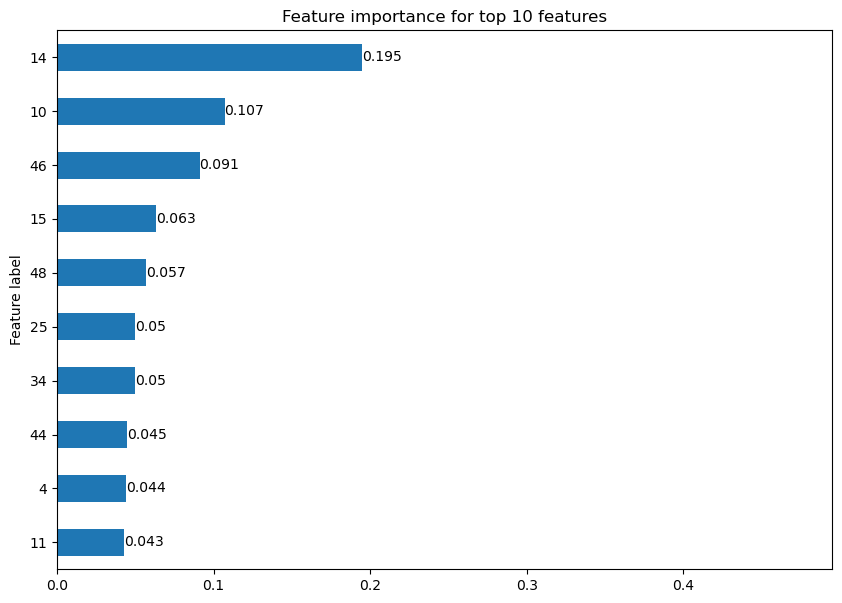

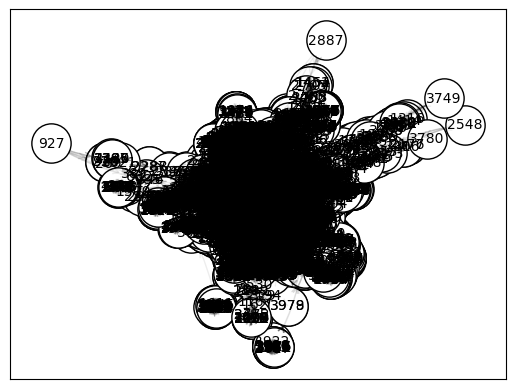

In [7]:
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

# Using same method to get edge type as in utils.py
explanation = explainer(test_loader.data.x, test_loader.data.edge_index, index=1, captum_target=0)
print(explanation.edge_mask.shape)
print(explanation.node_mask.shape)
explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

torch.Size([42223])
torch.Size([4236, 67])


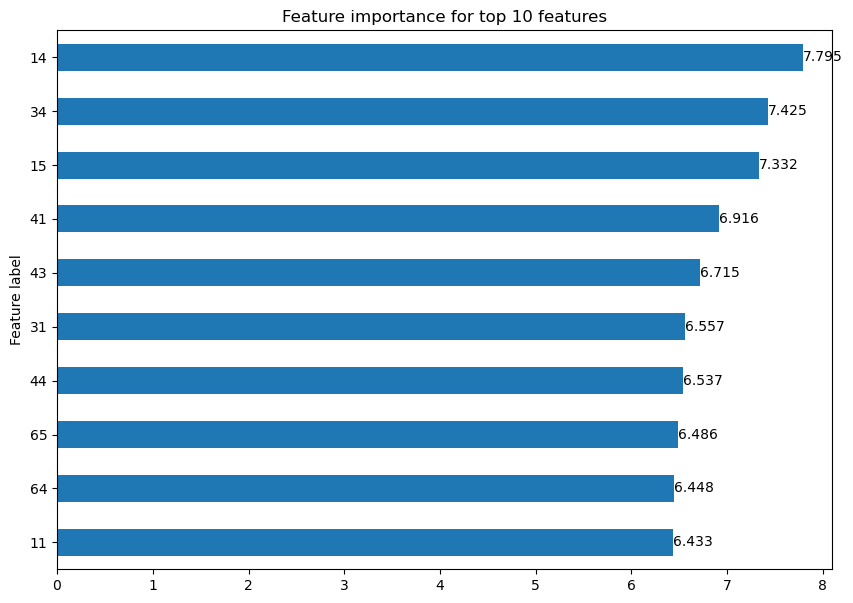

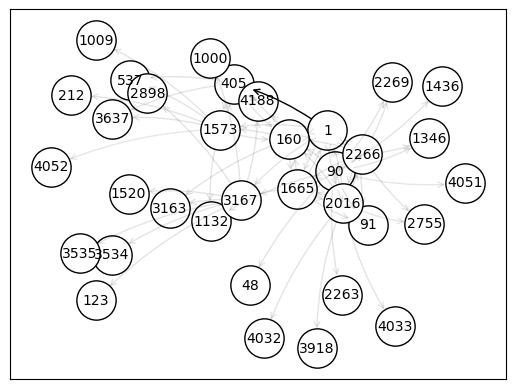

In [8]:
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explanation = explainer(test_loader.data.x, test_loader.data.edge_index, index=1, captum_target=0)
print(explanation.edge_mask.shape)
print(explanation.node_mask.shape)
explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

# Heterograph

## Data and Model Setup

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import HGTLoader
from torch_geometric.nn import HGTConv, Linear
from utils import evaluation
import pandas as pd

In [2]:
data = torch.load('data/processed/data_hetero.pt')
# print(f"Data objects: {data}")
kwargs = {'batch_size': 64, 'num_workers': 0, 'persistent_workers': False}
# Creating heterogeneous graph training, validation, and test loaders
train_loader = HGTLoader(data, num_samples={'node': [512] * 2}, shuffle=True,
                         input_nodes=('node', data['node'].train_mask), **kwargs)
val_loader = HGTLoader(data, num_samples={'node': [512] * 2},
                       input_nodes=('node', data['node'].val_mask), **kwargs)
test_loader = HGTLoader(data, num_samples={'node': [512] * 2},
                        input_nodes=('node', data['node'].test_mask), **kwargs)

In [3]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['node'])

In [4]:
model_name = "HGT"
model = HGT(hidden_channels=64, out_channels=6, num_heads=2, num_layers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)
model.load_state_dict(torch.load('models/HGT_HGTLoader.pth'))

<All keys matched successfully>

In [5]:
results = evaluation(model_name, model, test_loader, device)
print(results)

              MSE   RMSE    MAE     R2
office      0.002  0.048  0.031  0.923
sustenance  0.002  0.040  0.025  0.951
transport   0.003  0.051  0.033  0.935
retail      0.003  0.058  0.039  0.890
leisure     0.005  0.072  0.046  0.826
residence   0.004  0.064  0.042  0.887


## Explanations

The code below computes the feature attributions and visualizes the aggregate importances of the top 10 most important features.

Parameters:
* `index`: The index of the node for which the explanation should be computed
* `target`: The index of the target output feature (office, sustenance, ...) for which the explanation should be computed

The raw explanation (`feature_importances`) is a matrix of shape `(num_nodes, num_features)` where an element `(i, j)` represents the estimated effect of the j-th feature of the i-th node on the final prediction. For the visualisation, the contributions from all the nodes are aggregated into a single contribution score per feature. Only the 10 most positively contributing features are displayed.

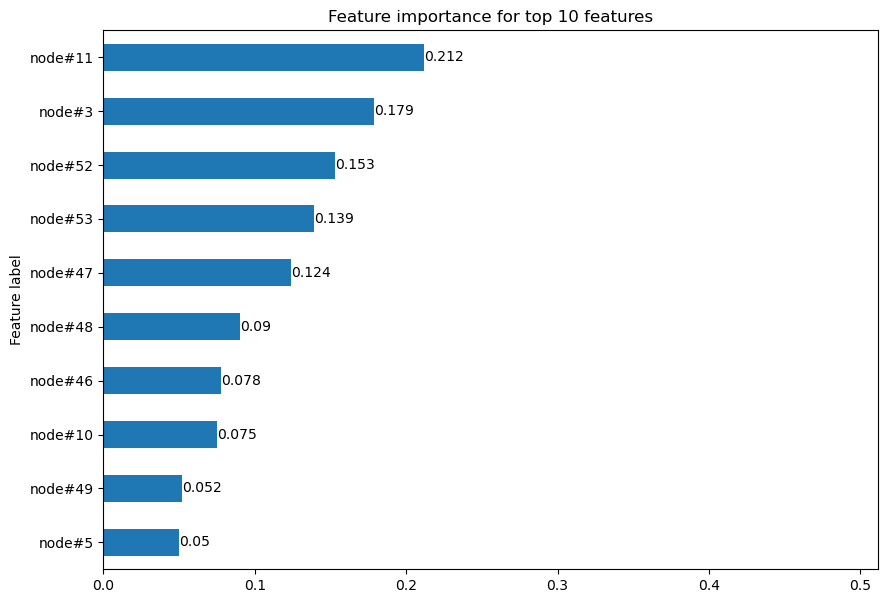

feature_importances shape: torch.Size([4236, 67])
aggregate_feature_importances shape: torch.Size([67])


In [15]:
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type='attributes',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

#########################
# Change this as needed #
#########################
index = 0
target = 0

explanation = explainer(test_loader.data.x_dict, test_loader.data.edge_index_dict, index=index, captum_target=target)
explanation.visualize_feature_importance(top_k=10)
feature_importances = explanation["node"].node_mask
print(f"feature_importances shape: {feature_importances.shape}")
aggregate_feature_importances = feature_importances.sum(dim=0)
print(f"aggregate_feature_importances shape: {aggregate_feature_importances.shape}")

/data/miniconda3/envs/gnn/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


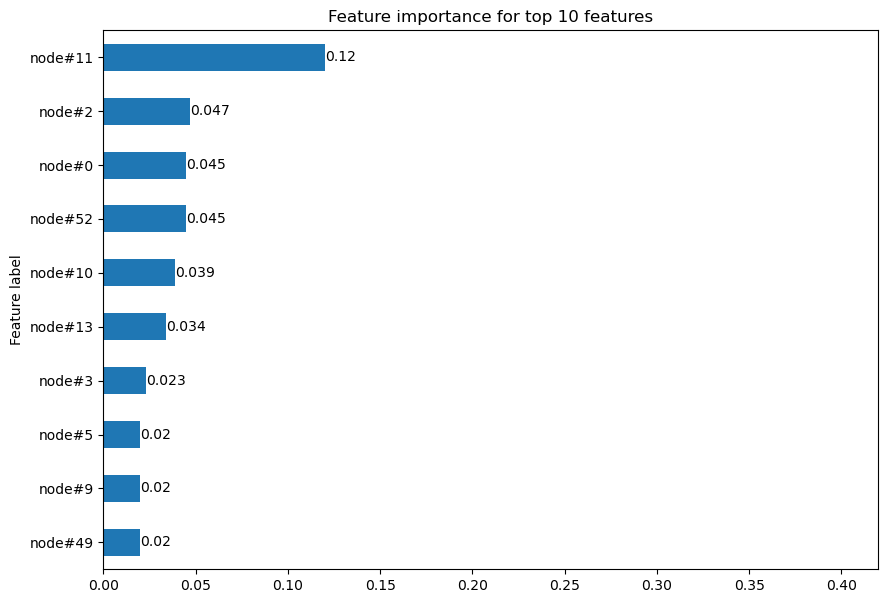

feature_importances shape: torch.Size([4236, 67])
aggregate_feature_importances shape: torch.Size([67])


In [16]:
from torch_geometric.explain import Explainer, CaptumExplainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('InputXGradient'),
    explanation_type='model',
    node_mask_type='attributes',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

#########################
# Change this as needed #
#########################
index = 0
target = 0

explanation = explainer(test_loader.data.x_dict, test_loader.data.edge_index_dict, index=index, captum_target=target)
explanation.visualize_feature_importance(top_k=10)
feature_importances = explanation["node"].node_mask
print(f"feature_importances shape: {feature_importances.shape}")
aggregate_feature_importances = feature_importances.sum(dim=0)
print(f"aggregate_feature_importances shape: {aggregate_feature_importances.shape}")